In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
from astropy.table import Table
roots_tfm = '/home/julien/Documents/Etudes/Astrofisica/Master/TFM/Data'

In [2]:
#df = dd.read_csv(roots_tfm + '/Galex/GUVCat_AIS_FOV055_glat50_00N__55_00N.csv', \
#                 names=['objid','ra','dec','tilenum','nuv_flux','nuv_fluxerr', \
#                         'fuv_flux','fuv_fluxerr','nuv_poserr'],header=0)
df = pd.read_csv(roots_tfm + '/Galex/GUVCat_AIS_FOV055_glat50_00N__55_00N_lite.csv')

In [3]:
df.head()

,objid,ra,dec,tilenum,fuv_flux,fuv_fluxerr,nuv_flux,nuv_fluxerr,nuv_poserr
0,6371267626052616299,238.739631,39.870670,50010,-999.0,-999.0,4.591824,2.013535,1.901696
1,6371267626052616307,238.774708,39.859621,50010,-999.0,-999.0,6.989871,2.655943,1.374202
2,6371267626052616315,238.657399,39.862831,50010,-999.0,-999.0,5.684222,2.096824,1.795104
3,6371267626052616319,238.751383,39.863806,50010,-999.0,-999.0,2.779190,1.211359,1.911447
4,6371267626052616321,238.747444,39.871978,50010,-999.0,-999.0,9.754148,2.279843,0.892572


In [4]:
df.dtypes

objid            int64
ra             float64
dec            float64
tilenum          int64
fuv_flux       float64
fuv_fluxerr    float64
nuv_flux       float64
nuv_fluxerr    float64
nuv_poserr     float64
dtype: object

In [5]:
df = df.rename(columns={'ra':'RA','dec':'DEC','nuv_poserr':'POSERR','objid':'SRCNUM',\
                       'nuv_flux':'NUV_FLUX', 'nuv_fluxerr' : 'NUV_FLUX_ERR', \
                         'fuv_flux': 'FUV_FLUX','fuv_fluxerr' : 'FUV_FLUX_ERR'})

In [6]:
df.head()

,SRCNUM,RA,DEC,tilenum,FUV_FLUX,FUV_FLUX_ERR,NUV_FLUX,NUV_FLUX_ERR,POSERR
0,6371267626052616299,238.739631,39.870670,50010,-999.0,-999.0,4.591824,2.013535,1.901696
1,6371267626052616307,238.774708,39.859621,50010,-999.0,-999.0,6.989871,2.655943,1.374202
2,6371267626052616315,238.657399,39.862831,50010,-999.0,-999.0,5.684222,2.096824,1.795104
3,6371267626052616319,238.751383,39.863806,50010,-999.0,-999.0,2.779190,1.211359,1.911447
4,6371267626052616321,238.747444,39.871978,50010,-999.0,-999.0,9.754148,2.279843,0.892572


In [7]:
df = df.astype({'SRCNUM': np.int64, 'NUV_FLUX': np.float32, 'FUV_FLUX': np.float32, \
                'NUV_FLUX_ERR': np.float32, 'FUV_FLUX_ERR': np.float32, 'RA': np.float64, \
                'DEC': np.float64, 'POSERR': np.float32, 'tilenum' : np.int32})

In [8]:
def create_source_ra_dec_file(df):

    # Treatment of points on the right ascension edge
    df_source_test = df.groupby('SRCNUM').agg({'RA' : 'std'})
    ind_src_ra_err = df_source_test[df_source_test['RA']>10].index
    if len(ind_src_ra_err)>0:
        ind_ra_err = (df['SRCNUM'].isin(ind_src_ra_err.values)) & (df['RA']>180)
        df.loc[ind_ra_err,'RA']  = df.loc[ind_ra_err,'RA'] - 360   

    # Computation of the weighted column and creation of the utils column to aggregate
    df['RA_weighted'] = df['RA']/df['POSERR']
    df['DEC_weighted'] = df['DEC']/df['POSERR']
    df['1/POSERR'] = 1/df['POSERR'].copy()
    df['COUNT'] = df['SRCNUM'].copy()

    # Aggregation
    df_source = df.groupby('SRCNUM').agg({'RA_weighted' : 'sum', 'DEC_weighted' : 'sum', 
                                         '1/POSERR': 'sum', 'POSERR': 'mean', 'COUNT': 'count'})
    
    # Computation of the weighted mean    
    df_source['DEC_weighted'] = df_source['DEC_weighted']/df_source['1/POSERR']
    df_source.loc[:, 'RA_weighted'] = df_source['RA_weighted']/df_source['1/POSERR']

    # Sanity check
    test = 0
    if df_source.loc[:, 'RA_weighted'].min() < 0:
        test = -1
        print('Sanity check start: Some points have a negative right ascension before correction')
    
    # Points on the edge are relocated in the right place if necessary (negative => +360°)
    df_source.loc[df_source.loc[:, 'RA_weighted']<0, 'RA_weighted'] = df_source.loc[df_source.loc[:, 'RA_weighted']<0, 'RA_weighted'] + 360

    # Sanity check end
    if test == -1:
        if df_source.loc[:, 'RA_weighted'].min() > 0:
            print('Sanity check ok: No negative right ascension remaining after correction')
        else:
            print('Error: Negative right ascension remaining!!')
    
    # Final cleaning
    df_source = df_source.rename(columns={'RA_weighted':'RA','DEC_weighted': 'DEC'}).drop('1/POSERR',axis=1)

    # File saving

    filepath = roots_tfm + '/Galex/Galex_ra_dec'
    t1 = Table.from_pandas(df_source,index=True)
    t1.write(filepath.split(".")[0] +'_per_src.fits',overwrite='True')

In [9]:
df_radec = df[['RA','DEC','POSERR','SRCNUM']]

In [10]:
#create_source_ra_dec_file(df_radec)

In [11]:
df_radec.shape

(2684047, 4)

In [12]:
df_entries = df[['SRCNUM','NUV_FLUX','NUV_FLUX_ERR','FUV_FLUX','FUV_FLUX_ERR','tilenum']]
#df_entries.to_csv(roots_tfm + '/Galex/Entries_Galex_glat50_00N_55_00N_csv')

In [13]:
import dask.dataframe as dd

In [14]:
dat = dd.read_parquet(roots_tfm + '/Swift-UVOT/Entries_UVOT_parquet')
df_UVOT_match = pd.read_csv(roots_tfm + '/Galex/Galex_match_with_UVOT')
dat_UVOT = dat[dat['SRCNUM'].isin(df_UVOT_match['SRCNUM_2'])].compute()

In [15]:
df_UVOT_match.head()

,SRCNUM_1,RA_1,DEC_1,POSERR_1,COUNT_1,SRCNUM_2,RA_2,DEC_2,POSERR_2,COUNT_2,Separation
0,6371443539323128042,238.770141,31.969308,1.544111,1,3538050,238.769872,31.969027,0.253550,1,0.723855
1,6371443539323128535,238.824752,32.061098,1.436998,1,3538868,238.824748,32.061218,0.120692,1,0.278862
2,6371443539323128659,238.762902,32.081977,1.760274,1,3537937,238.763448,32.081982,0.377161,1,0.779321
3,6371443539323128927,238.768725,32.127717,1.677247,1,3538025,238.768114,32.127752,0.305985,1,0.941613
4,6371443539323129054,238.779030,32.151065,1.741556,1,3538180,238.778699,32.151294,0.121286,1,0.699666


In [16]:
#dat = dd.read_parquet(roots_tfm + '/XMM-Newton/Entries_OM_parquet')
#df_OM_match = pd.read_csv(roots_tfm + '/Galex/Galex_match_with_OM')
#dat_OM = dat[dat['SRCNUM'].isin(df_OM_match['SRCNUM_2'])].compute()

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [18]:
dat_UVOT.shape

(28696, 27)

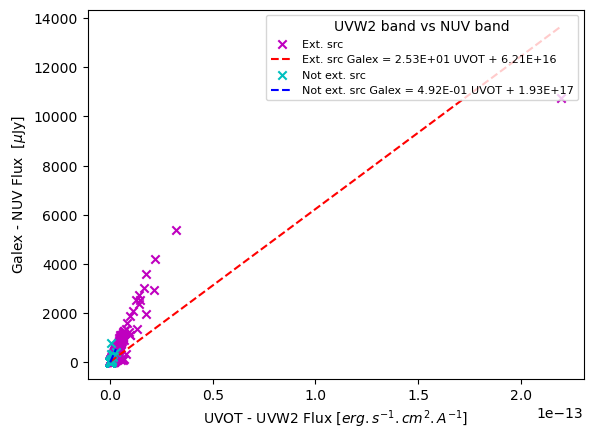

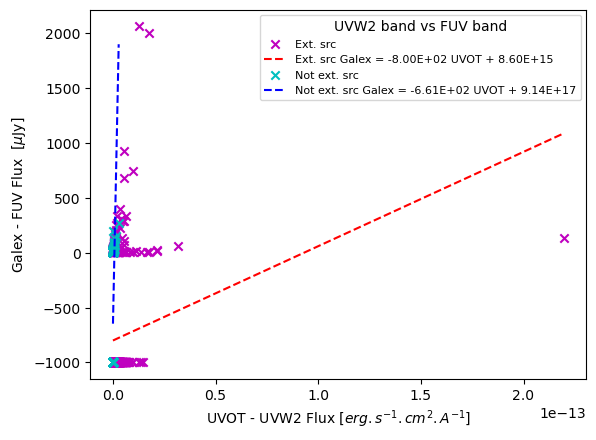

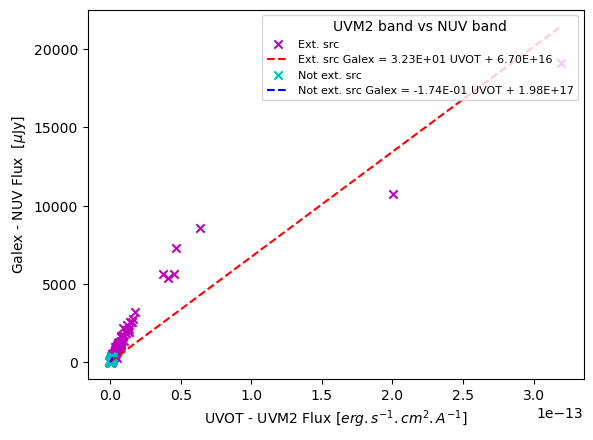

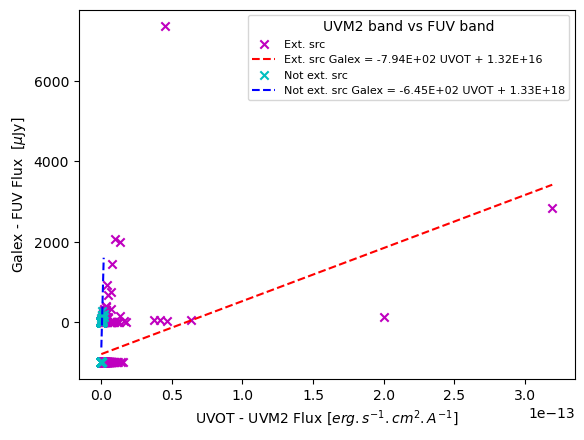

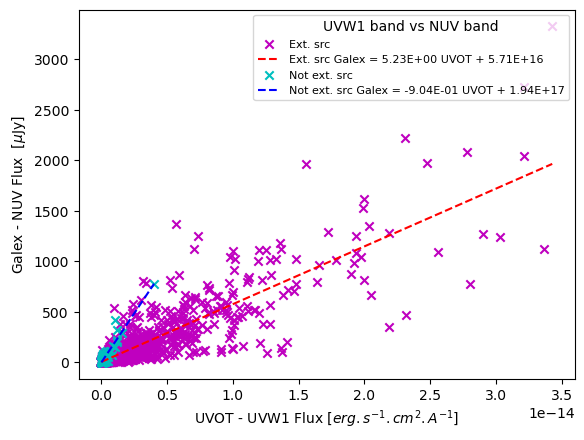

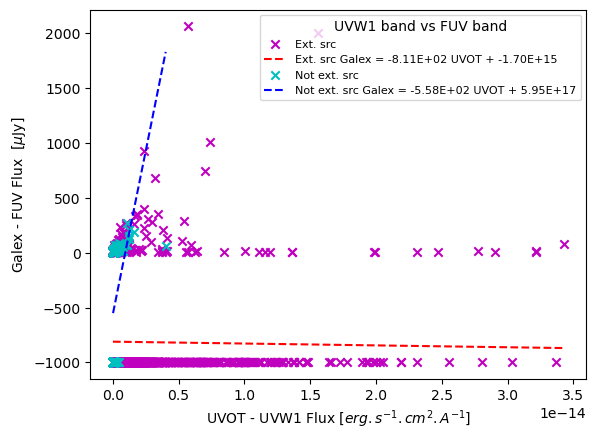

In [24]:
for flux in ['UVW2','UVM2','UVW1']: 
  
    flux_name = flux + '_FLUX'
    flux_err = flux + '_FLUX_ERR'
    flag_extended = flux + '_EXTENDED'
    flux_quality = flux + '_QUALITY_FLAG'

    # Dataframe UVOT for this band
    df_flux_uvot = dat_UVOT[['SRCNUM',flux_name,flux_err,flag_extended, flux_quality]].dropna(subset=[flux_name]).reset_index() 
    ind_minflux = df_flux_uvot.groupby('SRCNUM').agg({flux_err : 'idxmin'})[flux_err]
    df_flux_uvot = df_flux_uvot.loc[ind_minflux,:].rename(columns={flux_name: flux_name + '_UVOT', \
                                                                   flux_err: flux_err + '_UVOT', \
                                                                   flag_extended: flag_extended  + '_UVOT',\
                                                                   flux_quality: flux_quality + '_UVOT',\
                                                                   'SRCNUM': 'SRCNUM_2'})

    # Data frame OM for this band
    #df_flux_om = dat_OM[['SRCNUM',flux_name,flux_err]].dropna(subset=[flux_name]).reset_index()        
    #ind_minflux = df_flux_om.groupby('SRCNUM').agg({flux_err : 'idxmin'})[flux_err]
    #df_flux_om = df_flux_om.loc[ind_minflux,:].rename(columns={flux_name: flux_name + '_OM',\
    #                                                           flux_err: flux_err + '_OM', \
    #                                                           'SRCNUM': 'SRCNUM_2'})

    for flux_galex in ['NUV','FUV']:
        
        flux_galex_name = flux_galex + '_FLUX'
        flux_galex_err = flux_galex + '_FLUX_ERR'

         # Data frame Galex for this band
        df_flux_galex = df_entries[['SRCNUM',flux_galex_name,flux_galex_err]].dropna(subset=[flux_galex_name])
        df_flux_galex=df_flux_galex.reset_index().rename(columns={'SRCNUM': 'SRCNUM_1'})

        # Merge with UVOT results
        df_merge = df_UVOT_match.merge(df_flux_galex, on='SRCNUM_1').merge(df_flux_uvot, on='SRCNUM_2')

        # Plot figure
        fig, ax =plt.subplots()
        
        ind_extended = (df_merge[flag_extended+ '_UVOT'] == "False")
        ind_quality = (df_merge[flux_quality + '_UVOT'] == 0)
        
        ind1 = ind_extended & ind_quality 
        ax.scatter(df_merge.loc[ind1,flux_name + '_UVOT'], df_merge.loc[ind1,flux_galex_name], c='m',marker='x', \
                   label='Ext. src')
        z = np.polyfit(df_merge.loc[ind1,flux_name + '_UVOT'],df_merge.loc[ind1,flux_galex_name], deg=1)
        p = np.poly1d(z)
        xp = np.linspace(df_merge.loc[ind1,flux_name + '_UVOT'].min(), df_merge.loc[ind1,flux_name + '_UVOT'].max(), 100)
        ax.plot(xp,p(xp), color='r', linestyle='dashed', label= "Ext. src Galex = " + 
                  "{:.2E}".format(p[0]) + " UVOT + " + "{:.2E}".format(p[1]))

        ind2 = ~ind_extended & ind_quality
        ax.scatter(df_merge.loc[ind2,flux_name + '_UVOT'], df_merge.loc[ind2,flux_galex_name], c='c',marker='x', \
                   label='Not ext. src')
        z = np.polyfit(df_merge.loc[ind2,flux_name + '_UVOT'],df_merge.loc[ind2,flux_galex_name], deg=1)
        p = np.poly1d(z)
        xp = np.linspace(df_merge.loc[ind2,flux_name + '_UVOT'].min(), df_merge.loc[ind2,flux_name + '_UVOT'].max(), 100)
        ax.plot(xp,p(xp), color='b', linestyle='dashed', label= "Not ext. src Galex = " + 
                  "{:.2E}".format(p[0]) + " UVOT + " + "{:.2E}".format(p[1]))
        ax.set_xlabel("UVOT - " + flux + ' Flux [' + "$erg.s^{-1}.cm^{2}.A^{-1}]$")
        ax.set_ylabel("Galex - " + flux_galex + ' Flux  [' + "$\mu$" +"Jy]")
        ax.legend(loc='upper right',prop={'size': 8},title= flux + " band vs " + flux_galex + " band")
        fig.savefig(roots_tfm + '/Calibration/UVOT_' + flux + '_vs_Galex_ ' + flux_galex + "_glat50_00N__55_00N.png",dpi=1200)  